In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D , MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix

import seaborn as sns


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [4]:
#for cv2
#!pip install opencv-python

In [32]:
"""
path_to_model = "vgg16_customized.h5"
model = tf.keras.models.load_model(path_to_model)
model.summary()
"""

In [40]:
batch_size = 64
IMG_SIZE = (224, 224) #specific for VGG16
IMG_SHAPE = IMG_SIZE + (3,)


data_dir_test_balanced = os.path.join('dataset_final', 'TEST_BALANCED')
test_data_balanced = tf.keras.utils.image_dataset_from_directory(
  data_dir_test_balanced,
  image_size= IMG_SIZE,
  seed=1,
  batch_size= batch_size)

data_dir_test_unbalanced = os.path.join('dataset_final', 'TEST_UNBALANCED')
test_data_unbalanced = tf.keras.utils.image_dataset_from_directory(
  data_dir_test_unbalanced,
  image_size= IMG_SIZE,
  seed=1,
  batch_size= batch_size)



Found 796 files belonging to 4 classes.
Found 796 files belonging to 4 classes.
Using 159 files for validation.
Found 199 files belonging to 4 classes.


In [49]:
from keras import layers
model = Sequential()
model.add(Conv2D(64, 3,  input_shape=(224, 224, 3),padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))

model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 50176)           

In [59]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(test_data_balanced,epochs=10)

Epoch 1/10
13/13 [==============================] - 56s 4s/step - loss: 1.3280 - accuracy: 0.6394
Epoch 2/10
13/13 [==============================] - 48s 4s/step - loss: 0.6168 - accuracy: 0.7249
Epoch 3/10
13/13 [==============================] - 59s 5s/step - loss: 0.5030 - accuracy: 0.7940
Epoch 4/10
13/13 [==============================] - 64s 5s/step - loss: 0.4435 - accuracy: 0.8266
Epoch 5/10
13/13 [==============================] - 68s 5s/step - loss: 0.4084 - accuracy: 0.8530
Epoch 6/10
13/13 [==============================] - 66s 5s/step - loss: 0.3488 - accuracy: 0.8731
Epoch 7/10
13/13 [==============================] - 74s 6s/step - loss: 0.2649 - accuracy: 0.8970
Epoch 8/10
13/13 [==============================] - 67s 5s/step - loss: 0.2057 - accuracy: 0.9196
Epoch 9/10
13/13 [==============================] - 74s 6s/step - loss: 0.1986 - accuracy: 0.9372
Epoch 10/10
13/13 [==============================] - 79s 6s/step - loss: 0.1553 - accuracy: 0.9322


In [60]:
score = model.evaluate(test_data_balanced, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.947236180305481


In [61]:
score = model.evaluate(test_data_unbalanced, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.9698492288589478


In [62]:
def get_predictions_and_true_labels(test_data, model):
    """
    @inputs : test_data : the set you want the prediction
    WARNING : in this fuction, test_data must have the same form as the output of 
                tf.keras.utils.image_dataset_from_directory
              model : architecture used for the prediction
                
    @outpus : predictions and true labels 
    """
    predictions = np.array([])
    true_labels =  np.array([])
    for x, y in test_data: 
        predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
        true_labels = np.concatenate([true_labels, y.numpy()])
    return predictions, true_labels

In [63]:
predictions, true_labels = get_predictions_and_true_labels(test_data_balanced, model)

In [64]:
def show_confusion_matrix(predictions, true_labels):
    conf_mat = confusion_matrix(true_labels, predictions)
    map_period = { "Antiquity":0., "Contemporary_Era":1., "Middle_Ages":2.,"Modern_Times": 3.}
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True, xticklabels=map_period.keys(),
    yticklabels=map_period.keys(),
    fmt="d")

    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

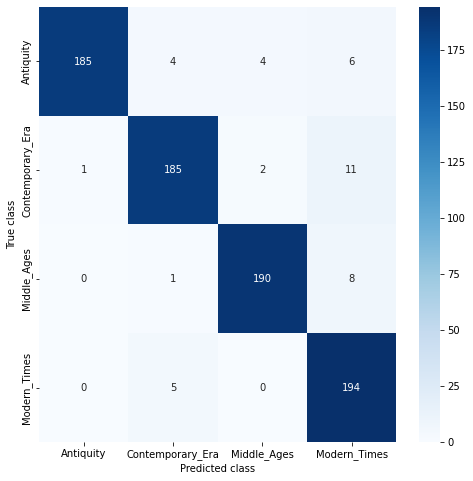

In [65]:
show_confusion_matrix(predictions, true_labels)

In [13]:
def predict_single_image(image_path,model, class_names, image_size):
    
    """
  @inputs : image_path : the path to the image we want to predict the class
            model : architecture used for the prediction
            class_names : the name of the 4 classes
  
  @output : show the image and give the class predicted by the model

    """
    
    #import the image and resize it for the model
    image_to_predict = cv2.imread(image_path,cv2.IMREAD_COLOR)
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict, image_size), axis=0) 
    
    #prediction of the class by the model
    res = np.argmax(model.predict(img_to_predict), axis=1)
    prediction = class_names[res[0]] #to have the name of the class instead of a number
    
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.title(f'prediction : {prediction}')
    plt.show()
    
    

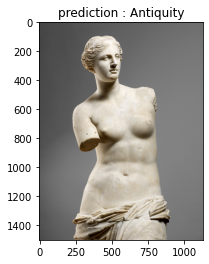

In [14]:
class_names = ['Antiquity', 'Contemporary_Era', 'Middle_Ages', 'Modern_Times']
image_path = 'louvre2.jpg'

predict_single_image(image_path,model, class_names, image_size=IMG_SIZE)